# 1. Building the dataset

### 1.1. Tomato

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("project-xoh6n").project("tomato-j0zeb")
# version = project.version(2)
# dataset = version.download("yolov8")


# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("practice-yolo").project("tomato-plxk0")
# version = project.version(10)
# dataset = version.download("yolov8")


# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("project-heksd").project("tomato-dwdwn")
# version = project.version(1)
# dataset = version.download("yolov8")


# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("uniprojectworkspace").project("tomato-geosx")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/tomato-2" "/content/drive/MyDrive/Colab Notebooks/PFE"
# !mv "/content/tomato-10" "/content/drive/MyDrive/Colab Notebooks/PFE"
# !mv "/content/tomato-1" "/content/drive/MyDrive/Colab Notebooks/PFE"
# !mv "/content/Tomato-1" "/content/drive/MyDrive/Colab Notebooks/PFE"

### 1.2. onion

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("th-lzmrm").project("hanh_tay-cc5xk")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/HÀNH_TÂY--1" "/content/drive/MyDrive/Colab Notebooks/PFE"

### 1.3. garlic

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("garlic-ccsom").project("garlic-sc8yu")
# version = project.version(2)
# dataset = version.download("yolov8") # garlic-2


# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("agriresearch-kjjix").project("garlic-class-dataset-l959l")
# version = project.version(4)
# dataset = version.download("yolov8") # Garlic-Class-Dataset-4



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("uniprojectworkspace").project("garlic-yowlv")
# version = project.version(1)
# dataset = version.download("yolov8") # Garlic-1



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("engelli").project("garlic-chicken")
# version = project.version(1)
# dataset = version.download("yolov8") # garlic-chiken-1


In [ ]:
# !mv "/content/garlic-2" "/content/drive/MyDrive/Colab Notebooks/PFE/garlic"
# !mv "/content/Garlic-Class-Dataset-4" "/content/drive/MyDrive/Colab Notebooks/PFE/garlic"
# !mv "/content/Garlic-1" "/content/drive/MyDrive/Colab Notebooks/PFE/garlic"
# !mv "/content/garlic-chicken-1" "/content/drive/MyDrive/Colab Notebooks/PFE/garlic"

### 1.4. potato

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("universe-mbjy3").project("potato-9tdgt")
# version = project.version(1)
# dataset = version.download("yolov8") # potato-1



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("food-altru").project("potatos-l93tz")
# version = project.version(2)
# dataset = version.download("yolov8") # potatos-2



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("snap-and-cook").project("potato-bwd40")
# version = project.version(1)
# dataset = version.download("yolov8") # Potato-1

In [ ]:
# !mv "/content/potato-1" "/content/drive/MyDrive/Colab Notebooks/PFE/potato"
# !mv "/content/potatos-2" "/content/drive/MyDrive/Colab Notebooks/PFE/potato"
# !mv "/content/Potato-1" "/content/drive/MyDrive/Colab Notebooks/PFE/potato"

### 1.5. carrot

In [ ]:
# # !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("practicas-djpmv").project("carrot-3askc")
# version = project.version(2)
# dataset = version.download("yolov8")



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("creative-ai-design-team1").project("carrot-gxdxi")
# version = project.version(1)
# dataset = version.download("yolov8")
# !mv "/content/carrot-1" "/content/carrot-3"


# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("2022project-s6pvv").project("carrot-y3aqm")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/Carrot-2" "/content/drive/MyDrive/Colab Notebooks/PFE/carrot"
# !mv "/content/carrot-1" "/content/drive/MyDrive/Colab Notebooks/PFE/carrot"
# !mv "/content/carrot-3" "/content/drive/MyDrive/Colab Notebooks/PFE/carrot"

### 1.6. egg

In [ ]:
# # !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("kmutt-jb3ax").project("egg-bnodj")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/egg-1" "/content/drive/MyDrive/Colab Notebooks/PFE/egg"

### 1.7. milk

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("smartshelftest01").project("milk-8woy9")
# version = project.version(4)
# dataset = version.download("yolov8")



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("pepper-robot-challenge").project("milk-fgxa8")
# version = project.version(1)
# dataset = version.download("yolov8")



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("object-detection-zcqbe").project("almond-breeze-milk-cgmna")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/Milk-4" "/content/drive/MyDrive/Colab Notebooks/PFE/milk"
# !mv "/content/milk-1" "/content/drive/MyDrive/Colab Notebooks/PFE/milk"
# !mv "/content/almond-breeze-milk-1" "/content/drive/MyDrive/Colab Notebooks/PFE/milk"

### 1.8. apple

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("manzana").project("apple-6pq7o")
# version = project.version(1)
# dataset = version.download("yolov8")



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("ned-university-1gy7w").project("apple-86zzo")
# version = project.version(1)
# dataset = version.download("yolov8")



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("shuno").project("apple-alll-d1wvv")
# version = project.version(2)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/apple-1" "/content/drive/MyDrive/Colab Notebooks/PFE/apple"
# !mv "/content/Apple--1" "/content/drive/MyDrive/Colab Notebooks/PFE/apple"
# !mv "/content/apple——alll-2" "/content/drive/MyDrive/Colab Notebooks/PFE/apple"

### 1.9. banana

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("frutas1-rx6mn").project("banana-smlod")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/banana-1" "/content/drive/MyDrive/Colab Notebooks/PFE/banana"

### 1.10. bread

In [ ]:
# # !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("project2-qzpko").project("bread-jljcv")
# version = project.version(6)
# dataset = version.download("yolov8")



# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("hanyang-ijbg8").project("bread-bv7l8")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/bread-6" "/content/drive/MyDrive/Colab Notebooks/PFE/bread"
# !mv "/content/bread-1" "/content/drive/MyDrive/Colab Notebooks/PFE/bread"

### 1.11. rice

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="qKISq30Dr5ITJcEsQUdD")
# project = rf.workspace("ll-hui4x").project("rice-t3fe5")
# version = project.version(1)
# dataset = version.download("yolov8")

In [ ]:
# !mv "/content/rice-1" "/content/drive/MyDrive/Colab Notebooks/PFE/rice"

# 2. check missing files in a given dataset

In [ ]:
import os
from pathlib import Path
from collections import defaultdict

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def scan_split(split_dir: Path):
    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"

    results = {
        "images_total": 0,
        "labels_total": 0,
        "images_missing_labels": [],
        "labels_missing_images": [],
        "image_ext_counts": defaultdict(int),
        "has_images_dir": images_dir.exists(),
        "has_labels_dir": labels_dir.exists(),
    }

    # If neither folder exists, nothing to scan
    if not images_dir.exists() and not labels_dir.exists():
        return results

    # Collect image stems
    image_stems = set()
    if images_dir.exists():
        for p in images_dir.iterdir():
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                results["images_total"] += 1
                results["image_ext_counts"][p.suffix.lower()] += 1
                image_stems.add(p.stem)

    # Collect label stems
    label_stems = set()
    if labels_dir.exists():
        for p in labels_dir.iterdir():
            if p.is_file() and p.suffix.lower() == ".txt":
                results["labels_total"] += 1
                label_stems.add(p.stem)

    # Only compare if both dirs exist
    if images_dir.exists() and labels_dir.exists():
        # Images missing labels
        for stem in sorted(image_stems - label_stems):
            # pick the existing image file regardless of extension
            for ext in IMG_EXTS:
                candidate = images_dir / f"{stem}{ext}"
                if candidate.exists():
                    results["images_missing_labels"].append(candidate)
                    break

        # Labels missing images
        for stem in sorted(label_stems - image_stems):
            results["labels_missing_images"].append(labels_dir / f"{stem}.txt")

    return results

def looks_like_roboflow_dataset(folder: Path) -> bool:
    """
    Treat it as a dataset if it contains at least one of train/valid/test folders.
    """
    return any((folder / s).exists() for s in ("train", "valid", "test"))

def scan_one_dataset(dataset_dir: Path, write_reports: bool = True):
    splits = ["train", "valid", "test"]

    overall = {
        "images_total": 0,
        "labels_total": 0,
        "images_missing_labels": [],
        "labels_missing_images": [],
        "image_ext_counts": defaultdict(int),
    }

    per_split = {}

    for s in splits:
        split_dir = dataset_dir / s
        if not split_dir.exists():
            continue

        r = scan_split(split_dir)
        per_split[s] = r

        overall["images_total"] += r["images_total"]
        overall["labels_total"] += r["labels_total"]
        overall["images_missing_labels"].extend(r["images_missing_labels"])
        overall["labels_missing_images"].extend(r["labels_missing_images"])
        for k, v in r["image_ext_counts"].items():
            overall["image_ext_counts"][k] += v

    # Print
    print(f"\n=== DATASET: {dataset_dir.name} ===")
    for s, r in per_split.items():
        print(f"[{s}] images={r['images_total']} labels={r['labels_total']}", end="")
        if r["has_images_dir"] and r["has_labels_dir"]:
            print(f" | img_missing_lbl={len(r['images_missing_labels'])} lbl_missing_img={len(r['labels_missing_images'])}")
        else:
            print(" | (missing images/ or labels/ folder)")

    print("--- totals ---")
    print(f"images={overall['images_total']} labels={overall['labels_total']}")
    print(f"images missing labels={len(overall['images_missing_labels'])}")
    print(f"labels missing images={len(overall['labels_missing_images'])}")

    # Reports
    if write_reports:
        report_dir = dataset_dir / "_integrity_reports"
        report_dir.mkdir(exist_ok=True)

        (report_dir / "images_missing_labels.txt").write_text(
            "\n".join(str(p) for p in overall["images_missing_labels"]) + ("\n" if overall["images_missing_labels"] else ""),
            encoding="utf-8"
        )
        (report_dir / "labels_missing_images.txt").write_text(
            "\n".join(str(p) for p in overall["labels_missing_images"]) + ("\n" if overall["labels_missing_images"] else ""),
            encoding="utf-8"
        )

    return overall

def scan_class_folder(class_folder: str, write_reports: bool = True):
    class_folder = Path(class_folder)
    if not class_folder.exists():
        print(f"❌ Folder not found: {class_folder}")
        return

    print(f"=== SCANNING CLASS FOLDER: {class_folder} ===")

    # Find dataset subfolders (exclude obvious non-dataset folders)
    candidates = [p for p in class_folder.iterdir() if p.is_dir() and not p.name.startswith(".")]
    datasets = [p for p in candidates if looks_like_roboflow_dataset(p)]

    if not datasets:
        print("⚠️ No datasets found (no subfolders containing train/valid/test).")
        return

    # Sort for consistent output
    datasets.sort(key=lambda p: p.name.lower())

    grand = {
        "images_total": 0,
        "labels_total": 0,
        "images_missing_labels": 0,
        "labels_missing_images": 0,
    }

    for ds in datasets:
        overall = scan_one_dataset(ds, write_reports=write_reports)
        grand["images_total"] += overall["images_total"]
        grand["labels_total"] += overall["labels_total"]
        grand["images_missing_labels"] += len(overall["images_missing_labels"])
        grand["labels_missing_images"] += len(overall["labels_missing_images"])

    print("\n=== GRAND TOTAL (all datasets in folder) ===")
    print(f"Total images: {grand['images_total']}")
    print(f"Total labels: {grand['labels_total']}")
    print(f"Images missing labels: {grand['images_missing_labels']}")
    print(f"Labels missing images: {grand['labels_missing_images']}")

# -------------------------
# USAGE EXAMPLE:
# Put banana class folder here:
# -------------------------
scan_class_folder(r"C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\tomato", write_reports=True)

# 3. inspect classes

In [1]:
import yaml
import os

def get_classes_from_yaml(yaml_path):
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    return data.get('names', {}), data.get('nc', 0)

def inspect_datasets(root_dir):
    for root, dirs, files in os.walk(root_dir):
        if 'data.yaml' in files:
            yaml_path = os.path.join(root, 'data.yaml')
            classes, num_classes = get_classes_from_yaml(yaml_path)
            print(f"Dataset: {os.path.basename(root)}")
            print(f"Number of classes: {num_classes}")
            print(f"Class names: {classes}\n")

inspect_datasets(r'C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets')

Dataset: Apple--1
Number of classes: 2
Class names: ['apple', 'damaged_apple']

Dataset: apple-1
Number of classes: 1
Class names: ['manzana_amarilla']

Dataset: apple——alll-2
Number of classes: 1
Class names: ['apples']

Dataset: banana-1
Number of classes: 1
Class names: ['banana']

Dataset: bread-1
Number of classes: 1
Class names: ['0']

Dataset: bread-6
Number of classes: 1
Class names: ['bread']

Dataset: carrot-1
Number of classes: 1
Class names: ['carrot']

Dataset: Carrot-2
Number of classes: 1
Class names: ['Carrot']

Dataset: carrot-3
Number of classes: 8
Class names: ['carrot', 'egg', 'half carrot', 'half onion', 'half zucchini', 'onion', 'potato', 'zucchini']

Dataset: egg-1
Number of classes: 1
Class names: ['eggsDetect - v1 2024-05-07 8-16pm']

Dataset: Garlic-1
Number of classes: 1
Class names: ['garlic']

Dataset: garlic-2
Number of classes: 1
Class names: ['garlic']

Dataset: garlic-chicken-1
Number of classes: 2
Class names: ['garlic', 'onion']

Dataset: Garlic-Class

In [2]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def visualize_class_samples(dataset_path, class_name, class_id, num_samples=5):
    # Paths
    images_dir = os.path.join(dataset_path, "train", "images")
    labels_dir = os.path.join(dataset_path, "train", "labels")

    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Filter images containing the class
    class_images = []
    for img_file in image_files:
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    if line.strip().split()[0] == str(class_id):
                        class_images.append(img_file)
                        break

    # Randomly select samples
    samples = random.sample(class_images, min(num_samples, len(class_images)))

    # Plot the samples
    plt.figure(figsize=(15, 5))
    for i, sample in enumerate(samples):
        img_path = os.path.join(images_dir, sample)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}\n{sample}")
        plt.axis('off')

    plt.show()

C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\apple\apple-1  0


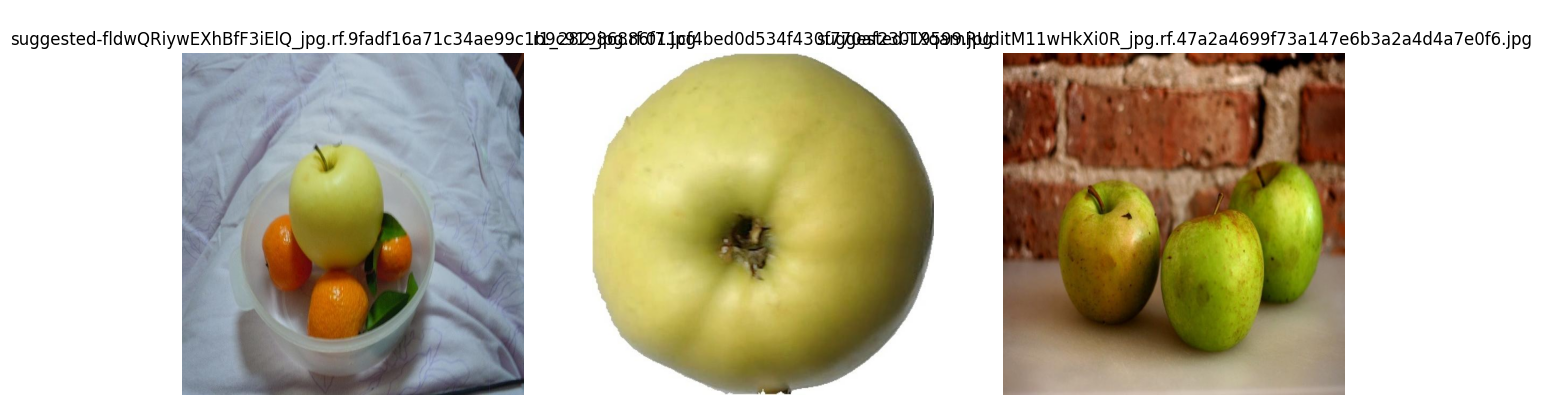

In [16]:
datasets = [
    {"path": r"C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\apple\apple-1", "class_name": "", "class_id": 0},
]

for dataset in datasets:
    print(dataset['path'], dataset['class_name'], dataset['class_id'])
    visualize_class_samples(dataset["path"], dataset["class_name"], dataset["class_id"], num_samples=3)

# 4. creating the final dataset

# 5. counting objects per class in final dataset

In [19]:
import os
from collections import Counter


MASTER_CLASSES = [
    'tomato', 'onion', 'garlic', 'potato', 'carrot',
    'egg', 'glass_milk', 'box_milk', 'apple', 'banana', 'bread', 'rice'
]

def count_final_objects(final_dir, class_list):
    # Initialize counter
    stats = {name: 0 for name in class_list}
    split_counts = {split: 0 for split in ['train', 'valid', 'test']}

    for split in ['train', 'valid', 'test']:
        label_path = os.path.join(final_dir, split, 'labels')
        if not os.path.exists(label_path):
            continue

        for file in os.listdir(label_path):
            if file.endswith('.txt'):
                split_counts[split] += 1
                with open(os.path.join(label_path, file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.split()[0])
                            class_name = class_list[class_id]
                            stats[class_name] += 1

    print("--- Final Dataset Statistics ---")
    print(f"Total Images: {sum(split_counts.values())} (Train: {split_counts['train']}, Val: {split_counts['valid']}, Test: {split_counts['test']})")
    print("-" * 30)
    print(f"{'Class Name':<15} | {'Object Count':<12}")
    print("-" * 30)

    for name, count in stats.items():
        alert = "⚠️ WEAK" if count < 100 else "" # Generally want at least 100-200 instances
        print(f"{name:<15} | {count:<12} {alert}")

# Run it
count_final_objects(r'C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\Final_Dataset', MASTER_CLASSES)

--- Final Dataset Statistics ---
Total Images: 19111 (Train: 15298, Val: 2329, Test: 1484)
------------------------------
Class Name      | Object Count
------------------------------
tomato          | 13476        
onion           | 4031         
garlic          | 24070        
potato          | 6190         
carrot          | 1415         
egg             | 41676        
glass_milk      | 571          
box_milk        | 1516         
apple           | 3084         
banana          | 336          
bread           | 204          
rice            | 1235         


=== SCANNING CLASS FOLDER: C:\Users\ahass\OneDrive\Desktop\notebooks\projects\PFE\datasets\tomato ===

=== DATASET: Tomato-1 ===
[train] images=2348 labels=2348 | img_missing_lbl=0 lbl_missing_img=0
[valid] images=106 labels=106 | img_missing_lbl=0 lbl_missing_img=0
[test] images=53 labels=53 | img_missing_lbl=0 lbl_missing_img=0
--- totals ---
images=2507 labels=2507
images missing labels=0
labels missing images=0

=== DATASET: tomato-10 ===
[train] images=618 labels=618 | img_missing_lbl=0 lbl_missing_img=0
[valid] images=53 labels=53 | img_missing_lbl=0 lbl_missing_img=0
[test] images=16 labels=16 | img_missing_lbl=0 lbl_missing_img=0
--- totals ---
images=687 labels=687
images missing labels=0
labels missing images=0

=== DATASET: tomato-2 ===
[train] images=86 labels=86 | img_missing_lbl=0 lbl_missing_img=0
[valid] images=37 labels=37 | img_missing_lbl=0 lbl_missing_img=0
--- totals ---
images=123 labels=123
images missing labels=0
labels missing images=0

=== GRAND TOTAL (all dat

# creating data.yaml

In [ ]:
# import yaml

# data_config = {
#     'path': '/content/drive/MyDrive/Colab Notebooks/PFE/Final_Dataset',  # root dir
#     'train': 'train/images',           # train images (relative to path)
#     'val': 'valid/images',             # val images (relative to path)
#     'test': 'test/images',             # test images (optional)

#     'nc': 12,
#     'names': [
#         'tomato', 'onion', 'garlic', 'potato', 'carrot',
#         'egg', 'glass_milk', 'box_milk', 'apple', 'banana', 'bread', 'rice'
#     ]
# }

# with open('/content/drive/MyDrive/Colab Notebooks/PFE/Final_Dataset/data.yaml', 'w') as f:
#     yaml.dump(data_config, f, default_flow_style=False)

# print("data.yaml created successfully!")

# Training YOLO

In [ ]:
# !pip install ultralytics

In [ ]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

In [ ]:
# from ultralytics import YOLO
# import torch

# model = YOLO('yolov8n.pt')

# results = model.train(
#     data='/content/drive/MyDrive/Colab Notebooks/PFE/Final_Dataset/data.yaml',
#     epochs=100,
#     imgsz=640,
#     batch=32,
#     device=0 if torch.cuda.is_available() else 'cpu',
#     workers=2,
#     cache='ram',
#     mosaic=1.0,
#     close_mosaic=10,
#     mixup=0.15,
#     cls=1.2,
#     warmup_epochs=3,
#     cos_lr=True,
#     label_smoothing=0.05,
#     half=True,
#     seed=42,
# )